In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
import bt_tools as bt

from scipy.stats import linregress

In [2]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')
data_2 = data.loc[(data['Z1'] >= 6) & (data['Z1'] <= 9) & (data['Z2'] >= 6) & (data['Z2'] <= 9)].to_dict('list')
data_3 = data.loc[(data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17)].to_dict('list')
data_4 = data.loc[(data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')
data_234 = data.loc[(data['Z1'] <= 9) & (data['Z2'] <= 9) | (data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17) | (data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')

for d in [data_2, data_3, data_4, data_234]:
    d['unit'] = 630
    d['bfe type'] = 'homo'
    
# do linear fits
b2 = bt.BDE_clean.fromdict(data_2)
b3 = bt.BDE_clean.fromdict(data_3)
b4 = bt.BDE_clean.fromdict(data_4)
for b in [b2, b3, b4]:
    b.linear_fit()
    rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
    rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
    print(f'MAE = {rounded_MAE} ({rounded_MAE_std})')

MAE = 0.51 (0.02)
MAE = 0.39 (0.03)
MAE = 0.33 (0.03)


### Why is the MAE of SRL* twice as high for the 3rd/4th row compared to the 2nd row?

The fit of the intercept n(Z) = -Z^{7/3} * a + b becomes less accurate - No, see below

In [3]:
def regression_n(bt_model):
    return(linregress(-np.unique(bt_model.Z1)**(7/3), bt_model.linear_params[:4]))

def mae_regression_n(bt_model, slope, intercept):
    n_pred = -np.unique(bt_model.Z1)**(7/3)*slope + intercept
    mae_n = (np.abs(n_pred-bt_model.linear_params[:4])).mean()
    return(mae_n)

In [4]:
for bt_model in [b2, b3, b4]:
    fit_n = regression_n(bt_model)
    mae_n = mae_regression_n(bt_model, fit_n[0], fit_n[1])
    print(f'MAE_n = {mae_n}')

MAE_n = 3.235591608419199
MAE_n = 6.572313759901554
MAE_n = 23.026760898987362


the error in n increases but the total MAE is the same for 3rd and 4th row (even somewhat higher for row 3) but the error in n is significantly
higher for row 4.

m is approximated by setting the intercept = 0

In [3]:
# non-linear fits

def non_linear_model(var, a, b, c):
    Z1, Z2 = var.T
    ebfe = -a**2 - b**2*Z1*Z2 -c**2*(Z1**(7/3)+Z2**(7/3))
    return(ebfe)

def non_linear_model2(var, a, b, c, d):
    Z1, Z2 = var.T
    ebfe = -a**2 - b**2*Z1*Z2 -c**2*(Z1**(7/3)+Z2**(7/3)) - d**2*(Z1+Z2)
    return(ebfe)

# do linear fits
b2_nl = bt.BDE_clean.fromdict(data_2)
b3_nl = bt.BDE_clean.fromdict(data_3)
b4_nl = bt.BDE_clean.fromdict(data_4)

for b in [b2_nl, b3_nl, b4_nl]:
    b.fit(non_linear_model)
    #print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))
    rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
    rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
    print(f'MAE = {rounded_MAE} ({rounded_MAE_std})')

MAE = 1.0 (0.04)
MAE = 2.35 (0.17)
MAE = 2.17 (0.21)


In [8]:
for b in [b2_nl, b3_nl, b4_nl]:
    p0 = [14.68820343, 24.89036036,  1.40953674, 1.9]
    b.fit(non_linear_model2, p0)
    #print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))
    rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
    rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
    print(f'MAE = {rounded_MAE} ({rounded_MAE_std})')

MAE = 1.0 (0.04)
MAE = 2.25 (0.16)
MAE = 2.17 (0.21)


error does not shrink after including intercept

In [50]:
def regression_m(bt_model):
    return(linregress(np.unique(bt_model.Z1), bt_model.linear_params[4:]))

def mae_regression_m(bt_model, slope, intercept):
    m_pred = np.unique(bt_model.Z1)*slope
    mae_m = (np.abs(m_pred-bt_model.linear_params[4:])).mean()
    return(mae_m)

In [58]:
for bt_model in [b2, b3, b4]:
    fit = regression_m(bt_model)
    mae = mae_regression_m(bt_model, fit[0], fit[1])
    print(f'MAE = {mae}')
    mean_m = (bt_model.linear_params[4:]).mean()
    print(f'relative MAE = {mean_m/mae}')

MAE = 3.7299474001645763
relative MAE = -624.0844877482359
MAE = 54.08571975528025
relative MAE = -89.95468872693034
MAE = 89.55191341561203
relative MAE = -117.74423808560603


In [56]:
b4.linear_params[4:]

array([-10075.38138735, -10389.11255914, -10700.56311238, -11011.83019805])

In [59]:
(b2.linear_params[4:]).mean()

-2327.8023125595737

In [60]:
b2.linear_params[4:]

array([-1863.63375531, -2171.8344303 , -2482.86217204, -2792.87889258])

In [68]:
print(np.array(data_2['d']).mean())

print(np.array(data_2['d']).std())

1.4209260451113332
0.03951613513788087


In [70]:
print(np.array(data_3['d']).mean())

print(np.array(data_3['d']).std())

2.1242470361150305
0.10957615917580538


In [71]:
print(np.array(data_4['d']).mean())

print(np.array(data_4['d']).std())

2.3617545069795702
0.05459063155952384


In [ ]:
row 3 has largest variation in bond length?

fit for row 2 fit different bond lengths?

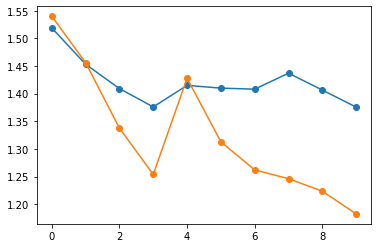

In [75]:
plt.plot(data_2['d'], '-o')
plt.plot(np.array(data_3['d'])-0.8, '-o')

In [13]:
b2.linear_params

array([ -207.46062624,  -269.66896789,  -324.2954636 ,  -398.26655654,
       -1863.63375531, -2171.8344303 , -2482.86217204, -2792.87889258])

In [13]:
# non-linear fits

def non_linear_model(var, a, b, c):
    Z1, Z2 = var.T
    ebfe = -a**2 - b**2*Z1*Z2 -c**2*(Z1**(7/3)+Z2**(7/3))
    return(ebfe)

def non_linear_model2(var, a, b, c, d):
    Z1, Z2 = var.T
    ebfe = -a**2 - b**2*Z1*Z2 -c**2*(Z1**(7/3)+Z2**(7/3)) - d**2*(Z1+Z2)
    return(ebfe)

# do linear fits
b2_nl = bt.BDE_clean.fromdict(data_2)
b3_nl = bt.BDE_clean.fromdict(data_3)
b4_nl = bt.BDE_clean.fromdict(data_4)

for b in [b2_nl, b3_nl, b4_nl]:
    b.fit(non_linear_model)
    #print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))
    rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
    rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
    print(f'MAE = {rounded_MAE} ({rounded_MAE_std})')

MAE = 1.0 (0.04)
MAE = 2.35 (0.17)
MAE = 2.17 (0.21)


In [14]:
reg_dict

{32.0: [-10075.381387352314, -183.90347682358447],
 33.0: [-10389.112559141588, -221.2149583358041],
 34.0: [-10700.563112377517, -350.30570718033823],
 35.0: [-11011.830198046187, -488.0425236957225]}

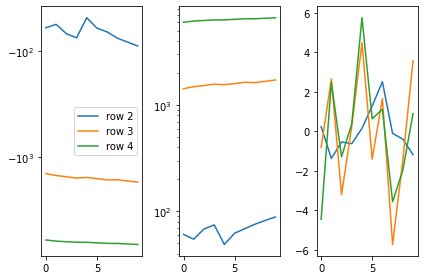

In [31]:
fig, ax = plt.subplots(1,3)

for row in [2,3,4]:
    if row == 2:
        bt_model_nl = b2_nl
        bt_model = b2
    elif row == 3:
        bt_model_nl = b3_nl
        bt_model = b3
    elif row == 4:
        bt_model_nl = b4_nl
        bt_model = b4
        
    a, b, c = bt_model_nl.params[0]**2
    #a, b, c, d = bt_model_nl.params[0]**2

# dict with Z:[m,n]
    intercepts = bt_model.linear_params[:4]
    slopes = bt_model.linear_params[4:]
    unique_charges = np.sort(np.unique(bt_model.Z1))

    reg_dict = dict()
    for Z, m, n in zip(unique_charges, slopes, intercepts):
        reg_dict[Z] = [m,n]

    m_contr = []
    n_contr = []
    m_contr_nl = []
    n_contr_nl = []
    for ZA, ZB in bt_model.xdata:
        # calculate slope contribution SRL
        mA = reg_dict[ZA][0]
        mB = reg_dict[ZB][0]
        m_contr.append(mA*ZB + mB*ZA)

        # calculate intercept contribution SRL
        nA = reg_dict[ZA][1]
        nB = reg_dict[ZB][1]
        n_contr.append(nA + nB)

        # calculate slope contribution SRL*
        m_contr_nl.append(-b*ZA*ZB)
        # calculate intercept contribution SRL*
        n_contr_nl.append(-c*(ZA**(7/3) + ZB**(7/3)) - a)

    m_contr = np.array(m_contr)
    n_contr = np.array(n_contr)
    m_contr_nl = np.array(m_contr_nl)
    n_contr_nl = np.array(n_contr_nl)

    ax[0].plot(m_contr-m_contr_nl, label = f'row {row}')
    ax[0].set_yscale('symlog')
    ax[1].set_yscale('log')
    ax[1].plot(n_contr-n_contr_nl)
    ax[2].plot(m_contr-m_contr_nl+n_contr-n_contr_nl)

    fig.tight_layout()
ax[0].legend()

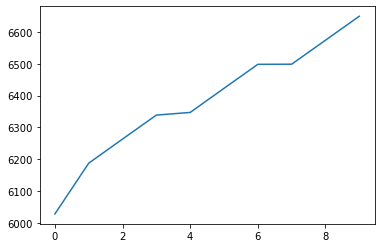

In [26]:
plt.plot(n_contr-n_contr_nl)

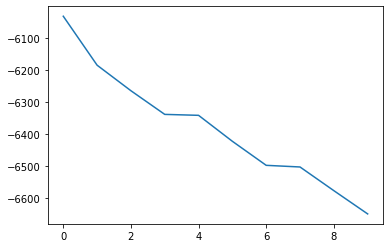

In [27]:
plt.plot(m_contr-m_contr_nl)

In [20]:
b4.linear_params

array([  -183.90347682,   -221.21495834,   -350.30570718,   -488.0425237 ,
       -10075.38138735, -10389.11255914, -10700.56311238, -11011.83019805])

In [21]:
b2_nl.params

(array([14.68820343, 24.89036036,  1.40953674]),
 array([[ 1.02136382e-02, -5.04618959e-04,  1.75519773e-03],
        [-5.04618959e-04,  4.26183073e-05, -1.63560862e-04],
        [ 1.75519773e-03, -1.63560862e-04,  6.36013981e-04]]))

In [22]:
b3_nl.params

(array([ 19.81709891, -24.92342996,   1.22294566]),
 array([[4.71486215e-01, 1.00419252e-02, 3.44385268e-02],
        [1.00419252e-02, 2.40022315e-04, 8.39349025e-04],
        [3.44385268e-02, 8.39349025e-04, 2.94426499e-03]]))

In [23]:
b4_nl.params

(array([33.30520795, 24.9763926 ,  0.90171052]),
 array([[ 3.07051975e+00, -2.50972721e-02,  9.20145300e-02],
        [-2.50972721e-02,  2.10130729e-04, -7.73508634e-04],
        [ 9.20145300e-02, -7.73508634e-04,  2.84923801e-03]]))

In [34]:
np.amax(b4.bde)-np.amin(b4.bde)

35.14433825606829